In [122]:
%matplotlib inline
from scipy import linalg
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Image
from math import (log,ceil,floor)
from scipy.fft import fft, ifft
from scipy.linalg import dft, inv, expm, norm
from numpy.linalg import matrix_power
from qiskit.quantum_info.analysis import hellinger_fidelity,hellinger_distance
from qiskit import( ClassicalRegister,
        QuantumRegister,
        QuantumCircuit,
        execute,
        Aer,
        IBMQ,
        transpile)
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import( plot_histogram,
                        plot_state_city,
                        plot_gate_map, 
                        plot_circuit_layout)
from qiskit.circuit.library import QFT
style = {'figwidth':10,'fontsize':17,'subfontsize':14}
styleWide = {'figwidth':25,'fontsize':20,'subfontsize':20}
style = {'figwidth':20,'fontsize':17,'subfontsize':14}
styleQft = {'figwidth':15,'fontsize':17,'subfontsize':14}
styleAdj = {'figwidth':15,'fontsize':17,'subfontsize':14 }
styleOracle = {'figwidth':17,'fontsize':20,'subfontsize':20}

plt.rcParams['figure.figsize'] = 11,8
matplotlib.rcParams.update({'font.size' : 15})

import warnings
warnings.filterwarnings("ignore")

In [100]:
def simul(qc,stateVec,shots):
    if stateVec:
        backend = Aer.get_backend('statevector_simulator')
        result = execute(qc,backend,shots=shots).result().get_statevector(qc,decimals=3)
    else:
        backend = Aer.get_backend('qasm_simulator')
        result = execute(qc,backend,shots=shots).result().get_counts()
    return result

def normalizedResultDict(baseDict,qiskitDict):
    "Returns the result of merging qiskit produced dictionaries with dictionaries produced from multBinResultDict for graph formatting reasons."
    new_d1 = baseDict
    new_d2= qiskitDict
    normalizedResultDict = {**new_d1,**new_d2}
    return normalizedResultDict

def decResultDict(n):
    "Retuns a dictionary composed of a range of N keys converted to binary."
    baseDict = {}
    for decNumber in range(2**n):
        dec = decNumber 
        baseDict[dec] = 0
    return baseDict

def resultsSim(N,circ,shots,Decimal):
    "Returns the dictionary produced by QASM simulator with the MSB changed to convention, and values (previously frequencies) converted to probabilities."
    result = simul(circ,False,shots)
    baseDict = decResultDict(N)
    if Decimal:
        correctedResultAux = { int(k,2) : v/shots for k, v in result.items()}
    else:
        correctedResultAux = { k : v/shots for k, v in result.items()}
    correctedResult = normalizedResultDict(baseDict,correctedResultAux)
    return correctedResult


In [101]:
def circulant_adjacency(n,v): #--- it computes an adjacency matrix for the circulant graph
    iv = list(range(0,n))
    av = list(range(0,n-1))
    C = np.zeros([n,n])
    for z in range(n):
        C[z,0] = v[iv[z]]
    for x in range(1,n):
        av = iv[0:-1]
        iv[0] = iv[-1]
        iv[1::] = av
        for y in range(0,n):
            C[y,x] = v[iv[y]]
    return C

def unitary_ctqw(gamma, N, A, marked, t): #---
    Oracle = np.zeros([N,N])
    for x in marked:
        Oracle[x,x] = 1
    U = expm(1j*(-gamma*A - Oracle)*t)
    return U

def exp_diag_qft(A,N):
    qft = dft(N, scale = 'sqrtn') #-- fourier transform
    iqft = inv(qft) #--
    D = np.diag(iqft@A@qft)
    D = np.exp(-1j*D)
    return list(D)

def diffusion_qc(expD, nq, qft_d):
    qreg = QuantumRegister(nq)
    qc = QuantumCircuit(qreg, name = 'Diagonal')
    qc.append(QFT(nq,do_swaps=False,approximation_degree = qft_d,inverse=True), range(nq))
    qc.diagonal(expD, qreg)
    qc.append(QFT(nq,do_swaps=False,approximation_degree = qft_d,inverse=False), range(nq))
    return qc

def oracleCont(N,markedList,t,r):
    O = np.zeros(N)
    for marked in markedList:
        O[marked] = 1
    O = list(np.exp(1j * O * t / r))
    return O

def oracleCirc(N,O):
    qreg = QuantumRegister(N)
    qc = QuantumCircuit(qreg,name='    Oracle    ')
    qc.diagonal(O,qreg)
    return qc

def contSearchCirc(N,NCirc,time,nTrotter,approxQFT,oracle,expD):
    qreg = QuantumRegister(NCirc)
    creg = ClassicalRegister(NCirc)
    qc = QuantumCircuit(qreg,creg)
    qcOracle = oracleCirc(NCirc,oracle)
    qcDiffusion = diffusion_qc(expD,NCirc,approxQFT)
    qc.h(qreg)
    qc.barrier()
    for n in range(nTrotter):
        qc.append(qcOracle,range(NCirc))
        qc.barrier()
        qc.append(qcDiffusion,range(NCirc))
        qc.barrier()
    qc.measure(qreg,creg)
    return qc

## Circuits

In [102]:
def oracleCirc(N,O):
    qreg = QuantumRegister(N)
    qc = QuantumCircuit(qreg,name='    Oracle    ')
    qc.diagonal(O,qreg)
    return qc

def drawDiffusion(expD, nq, qft_d):
    qreg = QuantumRegister(nq)
    qc = QuantumCircuit(qreg,name='     Adj     ')
    qc.append(QFT(nq,do_swaps=False,approximation_degree = qft_d,inverse=True), range(nq))
    qc.barrier()
    qc.diagonal(expD, qreg)
    qc.barrier()
    qc.append(QFT(nq,do_swaps=False,approximation_degree = qft_d,inverse=False), range(nq))
    return qc

def drawCirc(N,NCirc,time,nTrotter,approxQFT,oracle,expD):
    qreg = QuantumRegister(NCirc,'q')
    creg = ClassicalRegister(NCirc,'c')
    qc = QuantumCircuit(qreg,creg)
    qcOracle = oracleCirc(NCirc,oracle)
    qcDiffusion = drawDiffusion(expD,NCirc,approxQFT)
    qc.h(qreg)
    qc.barrier()
    for n in range(nTrotter):
        qc.append(qcOracle,range(NCirc))
        qc.append(QFT(nq,do_swaps=False,approximation_degree = approxQFT,inverse=True,name='    QFT    '), range(nq))
        qc.append(qcDiffusion,range(NCirc))
        qc.append(QFT(nq,do_swaps=False,approximation_degree = approxQFT,inverse=False,name='    IQFT    '), range(nq))
        qc.barrier()
    qc.measure(qreg,creg)
    return qc

### General

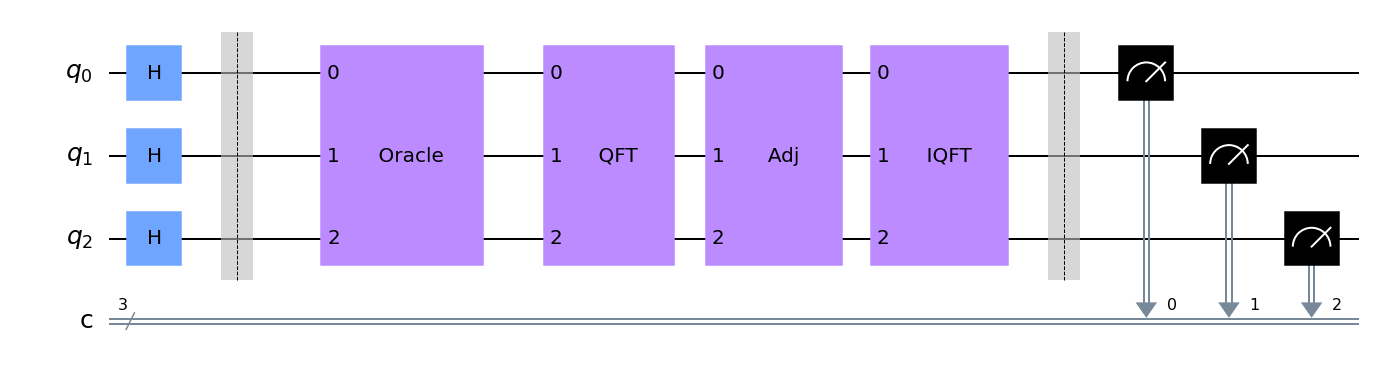

<Figure size 1800x481.796 with 0 Axes>

In [103]:
nq = 3
N = 2 ** nq
r2 = 2
r1 = 1
r=r1
shots = 3000
gamma = 1 / N
t = ((np.pi/2) * np.sqrt(N))
time = [0,t/2,t,t+t/2]
time = [round(x,2) for x in time]
markedList = [1]
approxQFT = 0
cComplete = [0]+[1 for x in range(N-1)]

A = circulant_adjacency(N, cComplete)
O = oracleCont(N,markedList,t,r)
expD = exp_diag_qft(-gamma * A * t / r, N)
#searchCirc = contSearchCirc(N,nq,t,r1,approxQFT,O,expD)
# searchResults = runWalkResults(searchCirc,shots)
drawCircuit = drawCirc(N,nq,t,r,approxQFT,O,expD)
display(drawCircuit.draw(output='mpl',style=styleWide))
plt.clf()
# display(plot_histogram(searchResults))
# plt.clf()


### Oracle

In [114]:
def drawOracleCirc(N,O):
    qreg = QuantumRegister(N,'q')
    qc = QuantumCircuit(qreg,name='    Oracle    ')
    qc.diagonal(O,qreg)
    qc = transpile(qc,basis_gates=['cp','h','cx','rz'])
    return qc

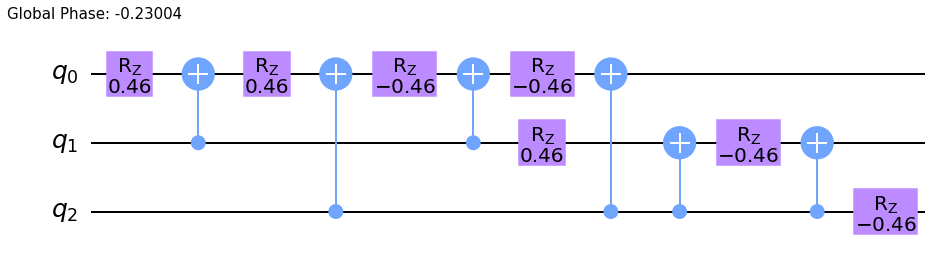

<Figure size 1224x309.678 with 0 Axes>

In [123]:
nq = 3
N = 2 ** nq
r2 = 2
r1 = 1
r=r1
shots = 3000
gamma = 1 / N
t = ((np.pi/2) * np.sqrt(N))
time = [0,t/2,t,t+t/2]
time = [round(x,2) for x in time]
markedList = [4]
approxQFT = 0
cComplete = [0]+[1 for x in range(N-1)]

A = circulant_adjacency(N, cComplete)
O = oracleCont(N,markedList,t,r)
expD = exp_diag_qft(-gamma * A * t / r, N)

oracleCirc = drawOracleCirc(nq,O)
display(oracleCirc.draw(output='mpl',style=styleOracle))
plt.clf()

### Adj

In [125]:
def drawAdjCirc(expD, nq):
    qreg = QuantumRegister(nq,'q')
    qc = QuantumCircuit(qreg,name='     Adj     ')
    qc.diagonal(expD, qreg)
    qc = transpile(qc,basis_gates=['cp','h','cx','rz'])
    return qc

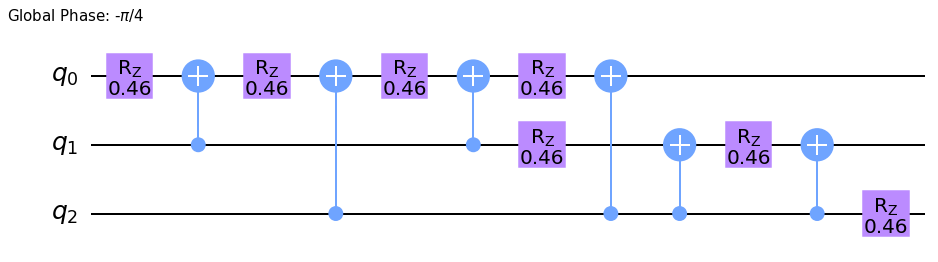

<Figure size 1224x309.678 with 0 Axes>

In [126]:
nq = 3
N = 2 ** nq
r2 = 2
r1 = 1
r=r1
shots = 3000
gamma = 1 / N
t = ((np.pi/2) * np.sqrt(N))
time = [0,t/2,t,t+t/2]
time = [round(x,2) for x in time]
markedList = [4]
approxQFT = 0
cComplete = [0]+[1 for x in range(N-1)]

A = circulant_adjacency(N, cComplete)
O = oracleCont(N,markedList,t,r)
expD = exp_diag_qft(-gamma * A * t / r, N)

adjCirc = drawAdjCirc(expD,nq)
display(adjCirc.draw(output='mpl',style=styleOracle))
plt.clf()

In [5]:
def multExpD(N,A,gamma,time,r):
    expDList = []
    qft = dft(N, scale = 'sqrtn') 
    iqft = inv(qft)
    for t in time:
        B = -gamma * A * t / r
        lambdA = iqft@B@qft
        D = np.diag(lambdA)
        D = np.exp(-1j*D)
        expDList.append(list(D))
    return expDList 

def multContSearchCirc(N,NCirc,timeList,nTrotter,approxQFT,oracle,expDList):
    circList = []
    for time,expD in zip(timeList,expDList):
        circ =  contSearchCirc(N,NCirc,time,nTrotter,approxQFT,oracle,expD)
        circList.append(circ)
    return circList

def multResultsSim(multipleCircs,shots):
    resultList = []
    result = {}
    correctedResult = {}
    for circ in multipleCircs:
        result = simul(circ,False,shots)
        correctedResult = { int(k,2) : v/shots for k, v in result.items()}
        resultList.append(correctedResult)
        result = {}
    return resultList

def multDecResultDict(N,steps):
    "Returns multiple binary dictionaries."
    baseResultDictList = []
    for step in steps:
        baseDict = decResultDict(N)
        baseResultDictList.append(baseDict)
    return baseResultDictList

def multNormalizedResultDict(baseDictList,qiskitDictList):
    normalizedResultDictList = []
    for baseDict,qiskitDict in zip(baseDictList,qiskitDictList):
        baseDict.update(qiskitDict)
        normalizedResultDictList.append(baseDict)
    return normalizedResultDictList
    
def multSubPlotIbmSim(resultListSim,resultListIbm,steps,backend):
    Tot = len(steps)
    Cols = 1
    # Compute Rows required
    Rows = Tot // Cols
    Rows += Tot % Cols
    # Create a Position index
    Position = range(1,Tot + 1)
    fig = plt.figure(1)
    i = 0
    for k,resultDictSim,resultDictIbm,step in zip(range(Tot),resultListSim,resultListIbm,steps):
            countsSim = resultDictSim.values()
            countsIbm = resultDictIbm.values()
            ax = fig.add_subplot(Rows,Cols,Position[k])
            if i ==0:
                ax.set_title("Time=%s"%step)
                ax.bar(*zip(*enumerate(countsSim)),width=-0.4,bottom=0,align='edge',label='qasm_simulator')
                ax.bar(*zip(*enumerate(countsIbm)),width= 0.4,bottom=0,align='edge',label=str(backend))
                ax.legend()
            else:
                ax.set_title("Time=%s"%step)
                ax.bar(*zip(*enumerate(countsSim)),width=-0.4,bottom=0,align='edge')
                ax.bar(*zip(*enumerate(countsIbm)),width=0.4,bottom=0,align='edge')
            plt.ylim(0,1.2)
            plt.yticks([0,0.5,1])
            plt.xlim(0-1,len(countsSim))
            w = ax.get_xaxis()
            if(i==Tot-1):
                w.set_visible(True)
                plt.xticks(range(0,len(countsSim)))
            else:
                w.set_visible(False)
            i+=1
    plt.xlabel("Graph Node")
    plt.ylabel("Probability")
    fig.tight_layout(pad=1.0)
    
def multSubPlotSim(resultListSim,steps):
    Tot = len(steps)
    Cols = 1
    # Compute Rows required
    Rows = Tot // Cols
    Rows += Tot % Cols
    # Create a Position index
    Position = range(1,Tot + 1)
    fig = plt.figure(1)
    i = 0
    for k,resultDictSim,step in zip(range(Tot),resultListSim,steps):
            countsSim = resultDictSim.values()
            ax = fig.add_subplot(Rows,Cols,Position[k])
            if i ==0:
                ax.set_title("Time=%s"%step)
                ax.bar(*zip(*enumerate(countsSim)),width=-0.4,bottom=0,align='edge',label='qasm_simulator')
                ax.legend()
            else:
                ax.set_title("Time=%s"%step)
                ax.bar(*zip(*enumerate(countsSim)),width=-0.4,bottom=0,align='edge')
            plt.ylim(0,1.2)
            plt.yticks([0,0.5,1])
            plt.xlim(0-1,len(countsSim))
            w = ax.get_xaxis()
            if(i==Tot-1):
                w.set_visible(True)
                plt.xticks(range(0,len(countsSim)))
            else:
                w.set_visible(False)
            i+=1
    plt.xlabel("Graph Node")
    plt.ylabel("Probability")
    fig.tight_layout(pad=1.0)

def plotMultipleQiskit(N,multipleCircs,steps,shots):
    qiskitSimResultList = multResultsSim(multipleCircs,shots)
    baseDictList = multDecResultDict(N,steps)
    normalizedResultDictList = multNormalizedResultDict(baseDictList,qiskitSimResultList)
    fig = multSubPlotSim(normalizedResultDictList,steps)
    return fig

def plotMultipleQiskitIbmSim(N,multResultSim,ibmJobDictList,steps,shots,Decimal,backend):
    "Brings every dictionar and plot building functions together to either show or save the matplotlib figure."
    formatedSimList = multResultSim
    decResultIBM = multDecResultDict(N,steps)
    decResultSIM = multDecResultDict(N,steps)
    normalizedResultListIbm = multNormalizedResultDict(decResultIBM,ibmJobDictList)
    normalizedResultListSim = multNormalizedResultDict(decResultSIM,formatedSimList)
    print("normalizedResultListIbm %s"%normalizedResultListIbm)
    print()
    print("normalizedResultListSim %s"%normalizedResultListSim)
    fig = multSubPlotIbmSim(normalizedResultListIbm,normalizedResultListSim,steps,backend)
    return fig

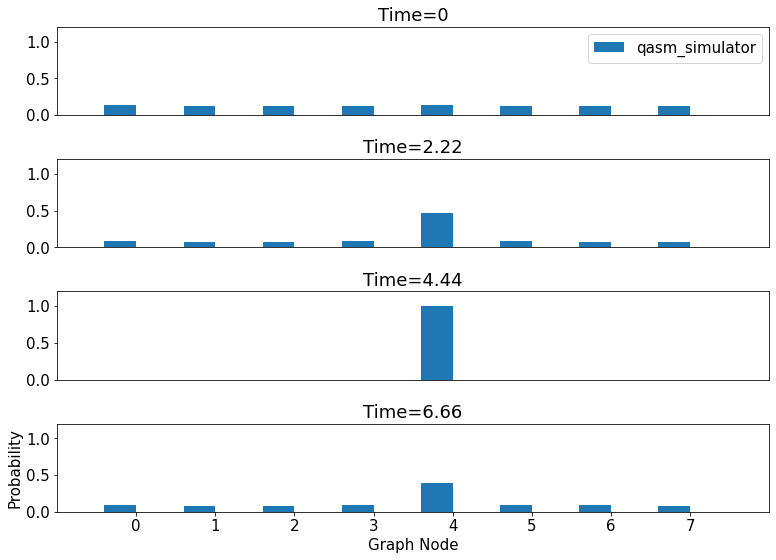

In [6]:
nq = 3
N = 2 ** nq
r2 = 2
r1 = 1
shots = 3000
t = ((np.pi/2) * np.sqrt(N))
gamma = 1 / N
time = [0,t/2,t,t+t/2]
timeList = [round(x,2) for x in time]
markedList = [4]
approxQFT = 0
cComplete = [0]+[1 for x in range(N-1)]

A = circulant_adjacency(N, cComplete)
orac = oracleCont(N,markedList,t,r2)
expDList = multExpD(N,A,gamma,timeList,r2)
multipleCircs = multContSearchCirc(N,nq,timeList,r2,approxQFT,orac,expDList)
plotMultipleQiskit(nq,multipleCircs,timeList,shots)
multResultSimN3 = multResultsSim(multipleCircs,shots)

In [7]:
IBMQ.save_account('97d2733b7c11b188b0581ae8a2beda54ce1c210ae0274df456ec1ddbe7df9fddf6d104015c59d4f7ce651304bf82fbd8e7178ea759d5f6f8058950d9e7ebf2ad')
IBMQ.load_account()
def getJob(jobID,provider,backend):
    job = backend.retrieve_job(jobID)
    resultCount = job.result().get_counts()
    return resultCount

def setProvider(hub,group,project):
    provider = IBMQ.get_provider(hub=hub, group=group, project=project)
    return provider

def leastBusy(minQubits,provider):
    large_enough_devices = provider.backends(filters=lambda x: x.configuration().n_qubits > minQubits  and not x.configuration().simulator)
    leastBusybackend = least_busy(large_enough_devices)
    return leastBusybackend

def listBackends(provider):
    for backend in provider.backends():
        print( backend.name())

def getJob(jobID,provider,backend):
    job = backend.retrieve_job(jobID)
    resultCount = job.result().get_counts()
    return resultCount

def run(circuit, backend, **kwargs):
    if type(backend) is str:
        backend = Aer.get_backend(backend)
    return execute(circuit, backend, **kwargs)

def printBestSeed(qc,basisGatesD,deviceBackend,startSeed,endSeed):
    dict = {}
    dict2 = {}
    for i in range(startSeed,endSeed):
        qCirc = transpile(qc,basis_gates=basisGatesD,backend=deviceBackend,optimization_level=3,layout_method='noise_adaptive',seed_transpiler=i)
        dict[i] = qCirc.count_ops()['cx']
        dict2[i] = qCirc.depth()
    print(min(dict.items(), key=lambda x: x[1])) 
    print(min(dict2.items(), key=lambda x: x[1]))

configrc.store_credentials:WARNING:2021-07-11 16:55:27,980: Credentials already present. Set overwrite=True to overwrite.


In [26]:
provider = setProvider('ibm-q-minho','academicprojects','quantalab')
##leastBusyBackend =leastBusy(10,provider)
##print("Least busy backend:",leastBusyBackend)
##32QV
bogBackend = provider.get_backend('ibmq_bogota')
# parisBackend = provider.get_backend('ibmq_paris')
manhatBackend = provider.get_backend('ibmq_manhattan')
torontoBackend = provider.get_backend('ibmq_toronto')
mumbaiBackend = provider.get_backend('ibmq_mumbai')
casablancaBackend = provider.get_backend('ibmq_casablanca')
yorkTown = provider.get_backend('ibmq_5_yorktown')
manila = provider.get_backend('ibmq_manila')
santiago = provider.get_backend('ibmq_santiago')
montreal = provider.get_backend('ibmq_montreal')


##Chosen
backend = santiago
backend2 = manila
backend3 = torontoBackend
backend4 = mumbaiBackend
backend5 = montreal
mumbaiGates = ['cx', 'id', 'rz', 'sx', 'x']
torontoGates = ['cx', 'id', 'rz', 'sx', 'x']

simulator = provider.get_backend('ibmq_qasm_simulator')
#method = 'noise_adaptive'
method = 'noise_adaptive'
#basisGatesD=['cx','rz','h','u3']
#printBestSeed(groverCircN3M0,basisGatesD,backend,0,100)

In [9]:
def contSearchCirc(N,NCirc,time,nTrotter,approxQFT,oracle,expD):
    qreg = QuantumRegister(NCirc)
    creg = ClassicalRegister(NCirc)
    qc = QuantumCircuit(qreg,creg)
    qcOracle = oracleCirc(NCirc,oracle)
    qcDiffusion = diffusion_qc(expD,NCirc,approxQFT)
    qc.h(qreg)
    qc.barrier()
    for n in range(nTrotter):
        qc.append(qcOracle,range(NCirc))
        qc.barrier()
        qc.append(qcDiffusion,range(NCirc))
        qc.barrier()
    qc.measure(qreg,creg)
    return qc

def runContSearchForIBM(N,NCirc,time,nTrotter,approxQFT,oracle,expD,backend,method,gates):
    qreg = QuantumRegister(NCirc)
    creg = ClassicalRegister(NCirc)
    qc = QuantumCircuit(qreg,creg)
    qcOracle = oracleCirc(NCirc,oracle)
    qcDiffusion = diffusion_qc(expD,NCirc,approxQFT)
    qc.h(qreg)
    for n in range(nTrotter):
        qc.append(qcOracle,range(NCirc))
        qc.append(qcDiffusion,range(NCirc))
    qc.measure(qreg,creg)
    qc = transpile(qc,backend,basis_gates = gates,layout_method=method,optimization_level=3)
    return qc

def executeCont(backend,method,gates,N,NCirc,timeList,nTrotter,approxQFT,oracle,expDList,shots):
    retrievedJobList = []
    for time,expD in zip(timeList,expDList):
        circ = runContSearchForIBM(N,NCirc,time,nTrotter,approxQFT,oracle,expD,backend,method,gates)
        job = execute([circ]*10,backend,shots=shots)
        retrievedJob = backend.retrieve_job(job.job_id())
        retrievedJobList.append(retrievedJob)
    return retrievedJobList

def getJobIds(jobList):
    jobIdList = []
    for job in jobList:
        jobIdList.append(job.job_id())
    return jobIdList

def retrieveJobsFromId(jobIdList,backend):
    retrievedJobList = []
    for jobId in jobIdList:
        retrievedJob = backend.retrieve_job(jobId)
        retrievedJobList.append(retrievedJob)
    return retrievedJobList

def getJobResults(jobList):
    multipleCountList = []
    for job in jobList:
        multipleCountList.append(job.result().get_counts())
    return multipleCountList

def multDictResults(resultList,shots):
    multResultList = []
    avgValue = 0
    for result in resultList:
        newResult = []
        for counts in result:
            correctedResult = { int(k,2) : v/shots for k, v in counts.items()}
            newResult.append(correctedResult)
        multResultList.append(newResult)
    return multResultList

## Simulator Backend

### R = 1

In [34]:
nq = 3
N = 2 ** nq
r2 = 2
r1 = 1
r = r1
shots = 3000
gamma = 1 / N
t = ((np.pi/2) * np.sqrt(N))
time = [0,t/2,t,t+t/2]
timeList = [round(x,2) for x in time]
markedList = [4]
approxQFT = 0
cComplete = [0]+[1 for x in range(N-1)]

A = circulant_adjacency(N, cComplete)
O = oracleCont(N,markedList,t,r)
bla = -gamma * A * t / r
expDList = multExpD(N,A,gamma,timeList,r)
# print(expDList)
#searchCirc = runContSearchForIBM(N,nq,t,r,approxQFT,O,expD,backend3,method,torontoGates)
#searchResults = runWalkResults(searchCirc,shots)
contSearchIbm = executeCont(simulator,method,torontoGates,N,nq,timeList,r,approxQFT,O,expDList,shots)

# display(searchCirc.draw(output='mpl',fold=-1))
# plt.clf()
# display(plot_histogram(searchResults))
# plt.clf()


### Multiple Results

In [35]:
jobIds = getJobIds(contSearchIbm)
print(jobIds)

['60eb165cedffca7459d810cc', '60eb1665af4ad838d9dff7be', '60eb16686b55251bd1a88b67', '60eb166cf5d647433dec40cf']


In [49]:
simulatorContSearchIdList = ['60eb165cedffca7459d810cc', '60eb1665af4ad838d9dff7be', '60eb16686b55251bd1a88b67', '60eb166cf5d647433dec40cf']
retrievedJobs = retrieveJobsFromId(simulatorContSearchIdList,simulator)

In [50]:
resultList = getJobResults(retrievedJobs)

In [51]:
shots = 3000
correctedResults = multDictResults(resultList,shots)

In [52]:
maxFidDict = maxFidIbmResultDict(correctedResults,multResultSimN3)

({0: 0.12166666666666667, 1: 0.12766666666666668, 2: 0.125, 3: 0.122, 4: 0.12433333333333334, 5: 0.11866666666666667, 6: 0.131, 7: 0.12966666666666668}, 0.9998250345660765)

({0: 0.08933333333333333, 1: 0.10066666666666667, 2: 0.106, 3: 0.09533333333333334, 4: 0.302, 5: 0.10066666666666667, 6: 0.109, 7: 0.097}, 0.9850465330509722)

({0: 0.05633333333333333, 1: 0.059666666666666666, 2: 0.050333333333333334, 3: 0.05466666666666667, 4: 0.607, 5: 0.056666666666666664, 6: 0.058666666666666666, 7: 0.056666666666666664}, 0.8037319789759871)

({0: 0.12533333333333332, 1: 0.13166666666666665, 2: 0.132, 3: 0.124, 4: 0.072, 5: 0.13633333333333333, 6: 0.143, 7: 0.13566666666666666}, 0.913765083800303)



normalizedResultListIbm [{0: 0.12066666666666667, 1: 0.13166666666666665, 2: 0.12333333333333334, 3: 0.112, 4: 0.12633333333333333, 5: 0.12466666666666666, 6: 0.13333333333333333, 7: 0.128}, {0: 0.07, 1: 0.08, 2: 0.06866666666666667, 3: 0.075, 4: 0.4666666666666667, 5: 0.08066666666666666, 6: 0.07766666666666666, 7: 0.08133333333333333}, {0: 0.0003333333333333333, 1: 0.0003333333333333333, 2: 0, 3: 0, 4: 0.9976666666666667, 5: 0.0006666666666666666, 6: 0.0006666666666666666, 7: 0.0003333333333333333}, {0: 0.094, 1: 0.07966666666666666, 2: 0.07733333333333334, 3: 0.09, 4: 0.4033333333333333, 5: 0.08366666666666667, 6: 0.08633333333333333, 7: 0.08566666666666667}]

normalizedResultListSim [{0: 0.12166666666666667, 1: 0.12766666666666668, 2: 0.125, 3: 0.122, 4: 0.12433333333333334, 5: 0.11866666666666667, 6: 0.131, 7: 0.12966666666666668}, {0: 0.08933333333333333, 1: 0.10066666666666667, 2: 0.106, 3: 0.09533333333333334, 4: 0.302, 5: 0.10066666666666667, 6: 0.109, 7: 0.097}, {0: 0.0563333

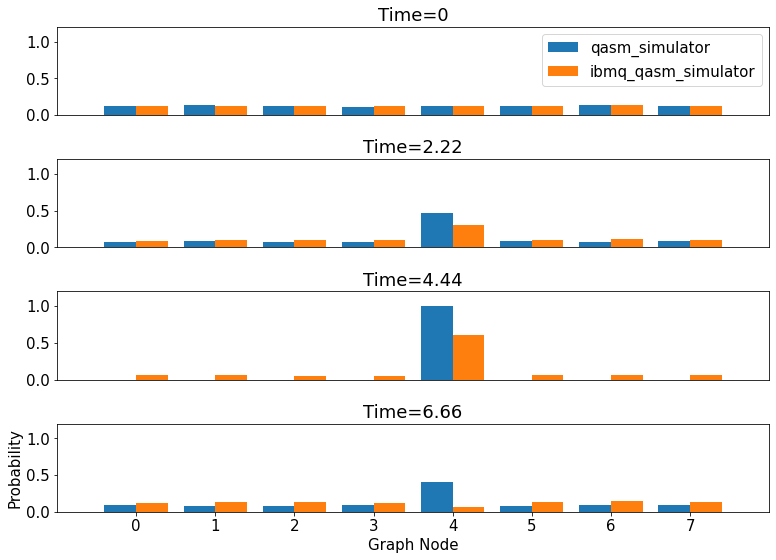

In [53]:
plotMultipleQiskitIbmSim(nq,maxFidDict,multResultSimN3,timeList,shots,True,simulator)

### R = 2

In [41]:
nq = 3
N = 2 ** nq
r2 = 2
r1 = 1
r = r2
shots = 3000
gamma = 1 / N
t = ((np.pi/2) * np.sqrt(N))
time = [0,t/2,t,t+t/2]
timeList = [round(x,2) for x in time]
markedList = [4]
approxQFT = 0
cComplete = [0]+[1 for x in range(N-1)]

A = circulant_adjacency(N, cComplete)
O = oracleCont(N,markedList,t,r)
bla = -gamma * A * t / r
expDList = multExpD(N,A,gamma,timeList,r)
# print(expDList)
#searchCirc = runContSearchForIBM(N,nq,t,r,approxQFT,O,expD,backend3,method,torontoGates)
#searchResults = runWalkResults(searchCirc,shots)
contSearchIbm = executeCont(simulator,method,torontoGates,N,nq,timeList,r,approxQFT,O,expDList,shots)

# display(searchCirc.draw(output='mpl',fold=-1))
# plt.clf()
# display(plot_histogram(searchResults))
# plt.clf()


In [42]:
jobIds = getJobIds(contSearchIbm)
print(jobIds)

['60eb170242e471e3ce275871', '60eb170679eac834998d76e7', '60eb170aaf4ad83168dff7c4', '60eb170eb5880872d16ce63d']


In [43]:
simulatorContSearchIdList = ['60eb170242e471e3ce275871', '60eb170679eac834998d76e7', '60eb170aaf4ad83168dff7c4', '60eb170eb5880872d16ce63d']
retrievedJobs = retrieveJobsFromId(simulatorContSearchIdList,simulator)

In [44]:
resultList = getJobResults(retrievedJobs)

In [45]:
shots = 3000
correctedResults = multDictResults(resultList,shots)

In [47]:
maxFidDict = maxFidIbmResultDict(correctedResults,multResultSimN3)

({0: 0.121, 1: 0.124, 2: 0.12466666666666666, 3: 0.124, 4: 0.122, 5: 0.12133333333333333, 6: 0.139, 7: 0.124}, 0.9997124113820051)

({0: 0.06933333333333333, 1: 0.07466666666666667, 2: 0.07266666666666667, 3: 0.08066666666666666, 4: 0.4716666666666667, 5: 0.07566666666666666, 6: 0.07666666666666666, 7: 0.07866666666666666}, 0.9998139354305482)

({1: 0.0003333333333333333, 4: 0.9983333333333333, 5: 0.0006666666666666666, 6: 0.0003333333333333333, 7: 0.0003333333333333333}, 0.9998046821872335)

({0: 0.086, 1: 0.086, 2: 0.07866666666666666, 3: 0.08633333333333333, 4: 0.4073333333333333, 5: 0.084, 6: 0.08666666666666667, 7: 0.085}, 0.9998226914339357)



normalizedResultListIbm [{0: 0.12066666666666667, 1: 0.13166666666666665, 2: 0.12333333333333334, 3: 0.112, 4: 0.12633333333333333, 5: 0.12466666666666666, 6: 0.13333333333333333, 7: 0.128}, {0: 0.07, 1: 0.08, 2: 0.06866666666666667, 3: 0.075, 4: 0.4666666666666667, 5: 0.08066666666666666, 6: 0.07766666666666666, 7: 0.08133333333333333}, {0: 0.0003333333333333333, 1: 0.0003333333333333333, 2: 0, 3: 0, 4: 0.9976666666666667, 5: 0.0006666666666666666, 6: 0.0006666666666666666, 7: 0.0003333333333333333}, {0: 0.094, 1: 0.07966666666666666, 2: 0.07733333333333334, 3: 0.09, 4: 0.4033333333333333, 5: 0.08366666666666667, 6: 0.08633333333333333, 7: 0.08566666666666667}]

normalizedResultListSim [{0: 0.121, 1: 0.124, 2: 0.12466666666666666, 3: 0.124, 4: 0.122, 5: 0.12133333333333333, 6: 0.139, 7: 0.124}, {0: 0.06933333333333333, 1: 0.07466666666666667, 2: 0.07266666666666667, 3: 0.08066666666666666, 4: 0.4716666666666667, 5: 0.07566666666666666, 6: 0.07666666666666666, 7: 0.07866666666666666}, 

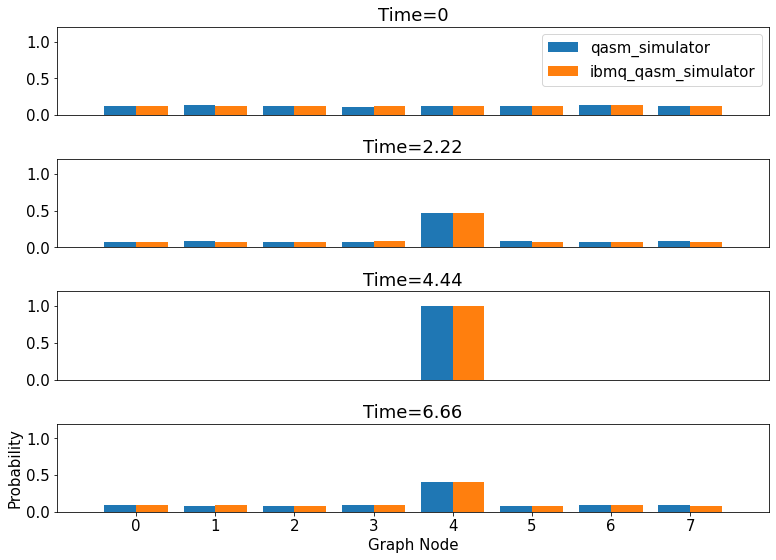

In [48]:
plotMultipleQiskitIbmSim(nq,maxFidDict,multResultSimN3,timeList,shots,True,simulator)

## QFT = 2

In [69]:
nq = 3
N = 2 ** nq
r2 = 2
r1 = 1
r = r2
shots = 3000
gamma = 1 / N
t = ((np.pi/2) * np.sqrt(N))
time = [0,t/2,t,t+t/2]
timeList = [round(x,2) for x in time]
markedList = [4]
approxQFT = 2
cComplete = [0]+[1 for x in range(N-1)]

A = circulant_adjacency(N, cComplete)
O = oracleCont(N,markedList,t,r)
bla = -gamma * A * t / r
expDList = multExpD(N,A,gamma,timeList,r)
# print(expDList)
#searchCirc = runContSearchForIBM(N,nq,t,r,approxQFT,O,expD,backend3,method,torontoGates)
#searchResults = runWalkResults(searchCirc,shots)
contSearchIbm = executeCont(simulator,method,torontoGates,N,nq,timeList,r,approxQFT,O,expDList,shots)

# display(searchCirc.draw(output='mpl',fold=-1))
# plt.clf()
# display(plot_histogram(searchResults))
# plt.clf()


In [70]:
jobIds = getJobIds(contSearchIbm)
print(jobIds)

['60eb1a18af4ad885b8dff7e1', '60eb1a1caf4ad83ed3dff7e2', '60eb1a206b55256b67a88b8b', '60eb1a22af4ad80c9fdff7e3']


In [71]:
simulatorContSearchIdList = ['60eb1a18af4ad885b8dff7e1', '60eb1a1caf4ad83ed3dff7e2', '60eb1a206b55256b67a88b8b', '60eb1a22af4ad80c9fdff7e3']
retrievedJobs = retrieveJobsFromId(simulatorContSearchIdList,simulator)

In [72]:
resultList = getJobResults(retrievedJobs)

In [73]:
shots = 3000
correctedResults = multDictResults(resultList,shots)

In [74]:
maxFidDict = maxFidIbmResultDict(correctedResults,multResultSimN3)

({0: 0.13233333333333333, 1: 0.13566666666666666, 2: 0.12633333333333333, 3: 0.11233333333333333, 4: 0.12366666666666666, 5: 0.12, 6: 0.124, 7: 0.12566666666666668}, 0.999721943466646)

({0: 0.07366666666666667, 1: 0.07366666666666667, 2: 0.07533333333333334, 3: 0.07066666666666667, 4: 0.4683333333333333, 5: 0.076, 6: 0.07633333333333334, 7: 0.086}, 0.9997309491223262)

({0: 0.0006666666666666666, 1: 0.0003333333333333333, 4: 0.9976666666666667, 5: 0.0006666666666666666, 6: 0.0003333333333333333, 7: 0.0003333333333333333}, 0.9999428090415821)

({0: 0.09533333333333334, 1: 0.07933333333333334, 2: 0.08833333333333333, 3: 0.084, 4: 0.4043333333333333, 5: 0.08433333333333333, 6: 0.08633333333333333, 7: 0.078}, 0.9996721380796912)



normalizedResultListIbm [{0: 0.12066666666666667, 1: 0.13166666666666665, 2: 0.12333333333333334, 3: 0.112, 4: 0.12633333333333333, 5: 0.12466666666666666, 6: 0.13333333333333333, 7: 0.128}, {0: 0.07, 1: 0.08, 2: 0.06866666666666667, 3: 0.075, 4: 0.4666666666666667, 5: 0.08066666666666666, 6: 0.07766666666666666, 7: 0.08133333333333333}, {0: 0.0003333333333333333, 1: 0.0003333333333333333, 2: 0, 3: 0, 4: 0.9976666666666667, 5: 0.0006666666666666666, 6: 0.0006666666666666666, 7: 0.0003333333333333333}, {0: 0.094, 1: 0.07966666666666666, 2: 0.07733333333333334, 3: 0.09, 4: 0.4033333333333333, 5: 0.08366666666666667, 6: 0.08633333333333333, 7: 0.08566666666666667}]

normalizedResultListSim [{0: 0.13233333333333333, 1: 0.13566666666666666, 2: 0.12633333333333333, 3: 0.11233333333333333, 4: 0.12366666666666666, 5: 0.12, 6: 0.124, 7: 0.12566666666666668}, {0: 0.07366666666666667, 1: 0.07366666666666667, 2: 0.07533333333333334, 3: 0.07066666666666667, 4: 0.4683333333333333, 5: 0.076, 6: 0.076

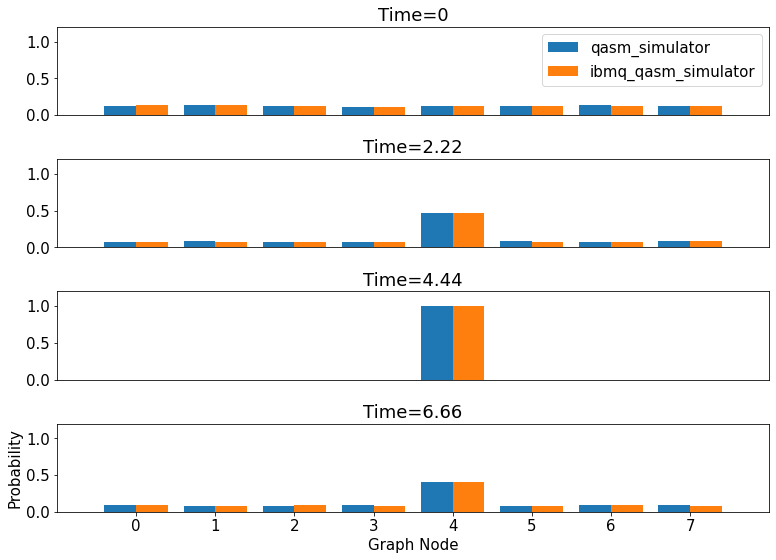

In [75]:
plotMultipleQiskitIbmSim(nq,maxFidDict,multResultSimN3,timeList,shots,True,simulator)

## Toronto

### R = 1

In [54]:
nq = 3
N = 2 ** nq
r2 = 2
r1 = 1
r = r1
shots = 3000
gamma = 1 / N
t = ((np.pi/2) * np.sqrt(N))
time = [0,t/2,t,t+t/2]
timeList = [round(x,2) for x in time]
markedList = [4]
approxQFT = 0
cComplete = [0]+[1 for x in range(N-1)]

A = circulant_adjacency(N, cComplete)
O = oracleCont(N,markedList,t,r)
bla = -gamma * A * t / r
expDList = multExpD(N,A,gamma,timeList,r)
# print(expDList)
# searchCirc = runContSearchForIBM(N,nq,t,r,approxQFT,O,expD,backend3,method,torontoGates)
# searchResults = runWalkResults(searchCirc,shots)
contSearchIbm = executeCont(backend3,method,torontoGates,N,nq,timeList,r,approxQFT,O,expDList,shots)

# display(searchCirc.draw(output='mpl',fold=-1))
# plt.clf()
# display(plot_histogram(searchResults))
# plt.clf()


In [55]:
jobIds = getJobIds(contSearchIbm)
print(jobIds)

['60eb17fc79eac89f838d76f2', '60eb1800a645534334ac1543', '60eb1803af4ad8dfacdff7cc', '60eb1806af4ad8d4c1dff7cd']


In [56]:
torontoContSearchIdList = ['60eb17fc79eac89f838d76f2', '60eb1800a645534334ac1543', '60eb1803af4ad8dfacdff7cc', '60eb1806af4ad8d4c1dff7cd']
retrievedJobs = retrieveJobsFromId(torontoContSearchIdList,backend3)

In [57]:
resultList = getJobResults(retrievedJobs)

In [58]:
shots = 3000
correctedResults = multDictResults(resultList,shots)


In [59]:
def fidDictList(results,multResultsSim):
    resultListFid = []
    resultListListFid = []
    for results,resultsSim in zip(correctedResults,multResultsSim):
        for resultDict in results:
            #print("IBM %s"%resultDict)
            #print("Sim %s"%resultsSim)
            hFid = (1-(hellinger_distance(resultsSim,resultDict))**2)
            #print("Hellinger fid %s"%(1-(hellinger_distance(resultsSim,resultDict))**2))
            resultListFid.append((resultDict,hFid))
        resultListListFid.append(resultListFid)
        resultListFid = []
    return resultListListFid

def maxFidIbmResultDict(results,multResultsSim):
    resultListFid = fidDictList(results,multResultsSim)
    maxFidDictList = []
    for a in resultListFid:
        maxFidDict = max(a,key=lambda x:x[1])
        print(maxFidDict)
        print()
        maxFidDictList.append(maxFidDict[0])
    return maxFidDictList

maxFidDict = maxFidIbmResultDict(correctedResults,multResultSimN3)
print(maxFidDict)
#print()
print(multResultSimN3)

({0: 0.21833333333333332, 1: 0.16233333333333333, 2: 0.112, 3: 0.12933333333333333, 4: 0.11166666666666666, 5: 0.10133333333333333, 6: 0.073, 7: 0.092}, 0.9847413138500637)

({0: 0.131, 1: 0.08433333333333333, 2: 0.10933333333333334, 3: 0.11466666666666667, 4: 0.16533333333333333, 5: 0.12466666666666666, 6: 0.11866666666666667, 7: 0.152}, 0.9425211063376506)

({0: 0.13866666666666666, 1: 0.11133333333333334, 2: 0.09033333333333333, 3: 0.08566666666666667, 4: 0.32066666666666666, 5: 0.081, 6: 0.09366666666666666, 7: 0.07866666666666666}, 0.5988753291810316)

({0: 0.12633333333333333, 1: 0.191, 2: 0.11833333333333333, 3: 0.105, 4: 0.14366666666666666, 5: 0.11566666666666667, 6: 0.10733333333333334, 7: 0.09266666666666666}, 0.9496542115644327)

[{0: 0.21833333333333332, 1: 0.16233333333333333, 2: 0.112, 3: 0.12933333333333333, 4: 0.11166666666666666, 5: 0.10133333333333333, 6: 0.073, 7: 0.092}, {0: 0.131, 1: 0.08433333333333333, 2: 0.10933333333333334, 3: 0.11466666666666667, 4: 0.1653333

normalizedResultListIbm [{0: 0.12066666666666667, 1: 0.13166666666666665, 2: 0.12333333333333334, 3: 0.112, 4: 0.12633333333333333, 5: 0.12466666666666666, 6: 0.13333333333333333, 7: 0.128}, {0: 0.07, 1: 0.08, 2: 0.06866666666666667, 3: 0.075, 4: 0.4666666666666667, 5: 0.08066666666666666, 6: 0.07766666666666666, 7: 0.08133333333333333}, {0: 0.0003333333333333333, 1: 0.0003333333333333333, 2: 0, 3: 0, 4: 0.9976666666666667, 5: 0.0006666666666666666, 6: 0.0006666666666666666, 7: 0.0003333333333333333}, {0: 0.094, 1: 0.07966666666666666, 2: 0.07733333333333334, 3: 0.09, 4: 0.4033333333333333, 5: 0.08366666666666667, 6: 0.08633333333333333, 7: 0.08566666666666667}]

normalizedResultListSim [{0: 0.21833333333333332, 1: 0.16233333333333333, 2: 0.112, 3: 0.12933333333333333, 4: 0.11166666666666666, 5: 0.10133333333333333, 6: 0.073, 7: 0.092}, {0: 0.131, 1: 0.08433333333333333, 2: 0.10933333333333334, 3: 0.11466666666666667, 4: 0.16533333333333333, 5: 0.12466666666666666, 6: 0.118666666666666

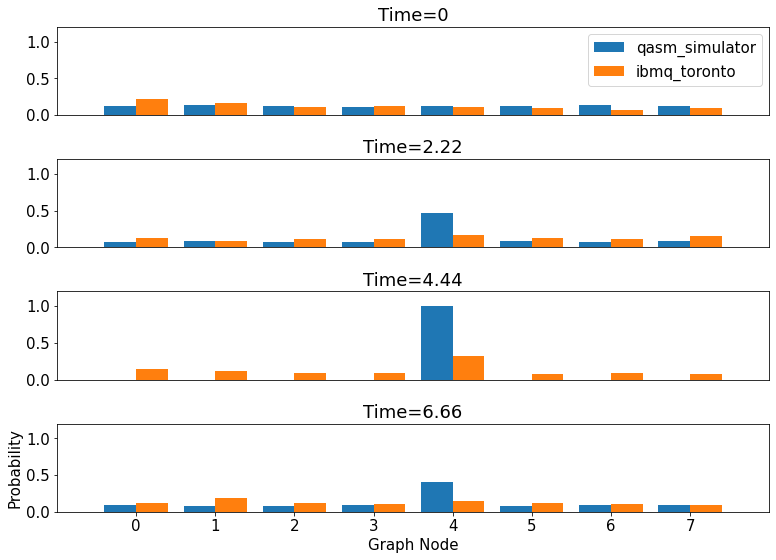

In [60]:
# print(maxFidDict)
# print(multResultSimN3)
plotMultipleQiskitIbmSim(nq,maxFidDict,multResultSimN3,timeList,shots,True,backend3)

### R = 2

In [61]:
nq = 3
N = 2 ** nq
r2 = 2
r1 = 1
r = r2
shots = 3000
gamma = 1 / N
t = ((np.pi/2) * np.sqrt(N))
time = [0,t/2,t,t+t/2]
timeList = [round(x,2) for x in time]
markedList = [4]
approxQFT = 0
cComplete = [0]+[1 for x in range(N-1)]

A = circulant_adjacency(N, cComplete)
O = oracleCont(N,markedList,t,r)
bla = -gamma * A * t / r
expDList = multExpD(N,A,gamma,timeList,r)
# print(expDList)
# searchCirc = runContSearchForIBM(N,nq,t,r,approxQFT,O,expD,backend3,method,torontoGates)
# searchResults = runWalkResults(searchCirc,shots)
contSearchIbm = executeCont(backend3,method,torontoGates,N,nq,timeList,r,approxQFT,O,expDList,shots)

# display(searchCirc.draw(output='mpl',fold=-1))
# plt.clf()
# display(plot_histogram(searchResults))
# plt.clf()


In [62]:
jobIds = getJobIds(contSearchIbm)
print(jobIds)

['60eb18eaa6455325e6ac1550', '60eb18efedffca4c1cd810eb', '60eb18f3af4ad827d9dff7d7', '60eb18f879eac8fa548d76fd']


In [63]:
torontoContSearchIdList = ['60eb18eaa6455325e6ac1550', '60eb18efedffca4c1cd810eb', '60eb18f3af4ad827d9dff7d7', '60eb18f879eac8fa548d76fd']
retrievedJobs = retrieveJobsFromId(torontoContSearchIdList,backend3)

In [64]:
resultList = getJobResults(retrievedJobs)

In [65]:
shots = 3000
correctedResults = multDictResults(resultList,shots)
# print(correctedResults)

In [66]:
maxFidDict = maxFidIbmResultDict(correctedResults,multResultSimN3)

({0: 0.16433333333333333, 1: 0.17066666666666666, 2: 0.13966666666666666, 3: 0.183, 4: 0.06466666666666666, 5: 0.10433333333333333, 6: 0.075, 7: 0.09833333333333333}, 0.981755189330447)

({0: 0.135, 1: 0.11833333333333333, 2: 0.09166666666666666, 3: 0.11266666666666666, 4: 0.16666666666666666, 5: 0.12333333333333334, 6: 0.119, 7: 0.13333333333333333}, 0.9446738335936089)

({0: 0.125, 1: 0.085, 2: 0.086, 3: 0.089, 4: 0.29833333333333334, 5: 0.11333333333333333, 6: 0.10066666666666667, 7: 0.10266666666666667}, 0.5800736446360395)

({0: 0.146, 1: 0.09566666666666666, 2: 0.10733333333333334, 3: 0.10466666666666667, 4: 0.21733333333333332, 5: 0.129, 6: 0.09166666666666666, 7: 0.10833333333333334}, 0.9778694286224174)



normalizedResultListIbm [{0: 0.12066666666666667, 1: 0.13166666666666665, 2: 0.12333333333333334, 3: 0.112, 4: 0.12633333333333333, 5: 0.12466666666666666, 6: 0.13333333333333333, 7: 0.128}, {0: 0.07, 1: 0.08, 2: 0.06866666666666667, 3: 0.075, 4: 0.4666666666666667, 5: 0.08066666666666666, 6: 0.07766666666666666, 7: 0.08133333333333333}, {0: 0.0003333333333333333, 1: 0.0003333333333333333, 2: 0, 3: 0, 4: 0.9976666666666667, 5: 0.0006666666666666666, 6: 0.0006666666666666666, 7: 0.0003333333333333333}, {0: 0.094, 1: 0.07966666666666666, 2: 0.07733333333333334, 3: 0.09, 4: 0.4033333333333333, 5: 0.08366666666666667, 6: 0.08633333333333333, 7: 0.08566666666666667}]

normalizedResultListSim [{0: 0.16433333333333333, 1: 0.17066666666666666, 2: 0.13966666666666666, 3: 0.183, 4: 0.06466666666666666, 5: 0.10433333333333333, 6: 0.075, 7: 0.09833333333333333}, {0: 0.135, 1: 0.11833333333333333, 2: 0.09166666666666666, 3: 0.11266666666666666, 4: 0.16666666666666666, 5: 0.12333333333333334, 6: 0.1

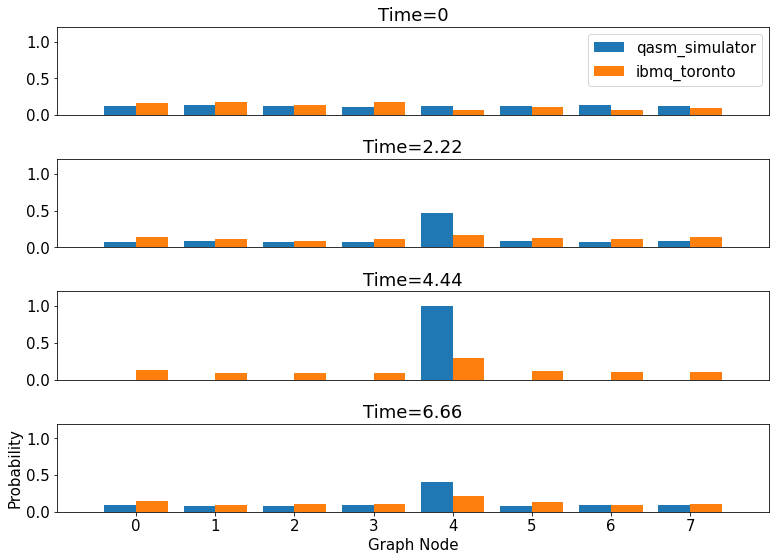

In [67]:
plotMultipleQiskitIbmSim(nq,maxFidDict,multResultSimN3,timeList,shots,True,backend3)

## QFT = 2

In [76]:
nq = 3
N = 2 ** nq
r2 = 2
r1 = 1
r = r2
shots = 3000
gamma = 1 / N
t = ((np.pi/2) * np.sqrt(N))
time = [0,t/2,t,t+t/2]
timeList = [round(x,2) for x in time]
markedList = [4]
approxQFT = 2
cComplete = [0]+[1 for x in range(N-1)]

A = circulant_adjacency(N, cComplete)
O = oracleCont(N,markedList,t,r)
bla = -gamma * A * t / r
expDList = multExpD(N,A,gamma,timeList,r)
# print(expDList)
# searchCirc = runContSearchForIBM(N,nq,t,r,approxQFT,O,expD,backend3,method,torontoGates)
# searchResults = runWalkResults(searchCirc,shots)
contSearchIbm = executeCont(backend3,method,torontoGates,N,nq,timeList,r,approxQFT,O,expDList,shots)

# display(searchCirc.draw(output='mpl',fold=-1))
# plt.clf()
# display(plot_histogram(searchResults))
# plt.clf()


In [77]:
jobIds = getJobIds(contSearchIbm)
print(jobIds)

['60eb1a915d7432565b7a9472', '60eb1a955d74323ba37a9473', '60eb1a98edffca800fd810fc', '60eb1a9cb588081c9c6ce661']


In [78]:
torontoContSearchIdList = ['60eb1a915d7432565b7a9472', '60eb1a955d74323ba37a9473', '60eb1a98edffca800fd810fc', '60eb1a9cb588081c9c6ce661']
retrievedJobs = retrieveJobsFromId(torontoContSearchIdList,backend3)

In [79]:
resultList = getJobResults(retrievedJobs)

In [80]:
shots = 3000
correctedResults = multDictResults(resultList,shots)
# print(correctedResults)

In [81]:
maxFidDict = maxFidIbmResultDict(correctedResults,multResultSimN3)

({0: 0.141, 1: 0.16033333333333333, 2: 0.151, 3: 0.10066666666666667, 4: 0.137, 5: 0.10533333333333333, 6: 0.095, 7: 0.10966666666666666}, 0.99555915641167)

({0: 0.09366666666666666, 1: 0.12466666666666666, 2: 0.14533333333333334, 3: 0.07633333333333334, 4: 0.2743333333333333, 5: 0.1, 6: 0.099, 7: 0.08666666666666667}, 0.9756624393964586)

({0: 0.10933333333333334, 1: 0.08433333333333333, 2: 0.08166666666666667, 3: 0.058, 4: 0.44133333333333336, 5: 0.07233333333333333, 6: 0.06533333333333333, 7: 0.08766666666666667}, 0.6938422906514958)

({0: 0.12933333333333333, 1: 0.117, 2: 0.08533333333333333, 3: 0.10766666666666666, 4: 0.2793333333333333, 5: 0.102, 6: 0.08066666666666666, 7: 0.09866666666666667}, 0.989902325072475)



normalizedResultListIbm [{0: 0.12066666666666667, 1: 0.13166666666666665, 2: 0.12333333333333334, 3: 0.112, 4: 0.12633333333333333, 5: 0.12466666666666666, 6: 0.13333333333333333, 7: 0.128}, {0: 0.07, 1: 0.08, 2: 0.06866666666666667, 3: 0.075, 4: 0.4666666666666667, 5: 0.08066666666666666, 6: 0.07766666666666666, 7: 0.08133333333333333}, {0: 0.0003333333333333333, 1: 0.0003333333333333333, 2: 0, 3: 0, 4: 0.9976666666666667, 5: 0.0006666666666666666, 6: 0.0006666666666666666, 7: 0.0003333333333333333}, {0: 0.094, 1: 0.07966666666666666, 2: 0.07733333333333334, 3: 0.09, 4: 0.4033333333333333, 5: 0.08366666666666667, 6: 0.08633333333333333, 7: 0.08566666666666667}]

normalizedResultListSim [{0: 0.141, 1: 0.16033333333333333, 2: 0.151, 3: 0.10066666666666667, 4: 0.137, 5: 0.10533333333333333, 6: 0.095, 7: 0.10966666666666666}, {0: 0.09366666666666666, 1: 0.12466666666666666, 2: 0.14533333333333334, 3: 0.07633333333333334, 4: 0.2743333333333333, 5: 0.1, 6: 0.099, 7: 0.08666666666666667}, {0

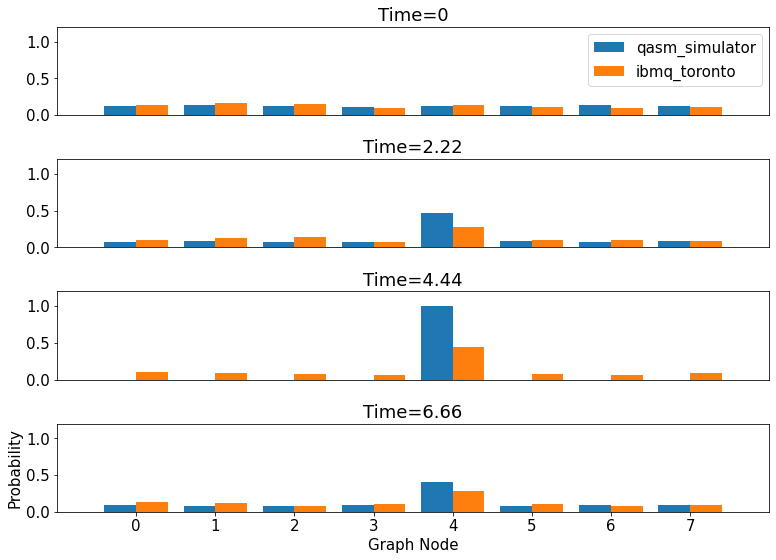

In [82]:
plotMultipleQiskitIbmSim(nq,maxFidDict,multResultSimN3,timeList,shots,True,backend3)

### QFT = 2 R = 1

In [83]:
nq = 3
N = 2 ** nq
r2 = 2
r1 = 1
r = r1
shots = 3000
gamma = 1 / N
t = ((np.pi/2) * np.sqrt(N))
time = [0,t/2,t,t+t/2]
timeList = [round(x,2) for x in time]
markedList = [4]
approxQFT = 2
cComplete = [0]+[1 for x in range(N-1)]

A = circulant_adjacency(N, cComplete)
O = oracleCont(N,markedList,t,r)
bla = -gamma * A * t / r
expDList = multExpD(N,A,gamma,timeList,r)
# print(expDList)
# searchCirc = runContSearchForIBM(N,nq,t,r,approxQFT,O,expD,backend3,method,torontoGates)
# searchResults = runWalkResults(searchCirc,shots)
contSearchIbm = executeCont(backend3,method,torontoGates,N,nq,timeList,r,approxQFT,O,expDList,shots)

# display(searchCirc.draw(output='mpl',fold=-1))
# plt.clf()
# display(plot_histogram(searchResults))
# plt.clf()


In [84]:
jobIds = getJobIds(contSearchIbm)
print(jobIds)

['60eb2020f5d6471c24ec412c', '60eb2023a64553e167ac1599', '60eb2026e290d471c77b8695', '60eb20296b5525cc51a88bc3']


In [85]:
torontoContSearchIdList = ['60eb2020f5d6471c24ec412c', '60eb2023a64553e167ac1599', '60eb2026e290d471c77b8695', '60eb20296b5525cc51a88bc3']
retrievedJobs = retrieveJobsFromId(torontoContSearchIdList,backend3)

In [86]:
resultList = getJobResults(retrievedJobs)

In [87]:
shots = 3000
correctedResults = multDictResults(resultList,shots)
# print(correctedResults)

In [88]:
maxFidDict = maxFidIbmResultDict(correctedResults,multResultSimN3)

({0: 0.11666666666666667, 1: 0.13133333333333333, 2: 0.13, 3: 0.136, 4: 0.12866666666666668, 5: 0.103, 6: 0.12733333333333333, 7: 0.127}, 0.998799643451216)

({0: 0.097, 1: 0.106, 2: 0.09266666666666666, 3: 0.12966666666666668, 4: 0.19733333333333333, 5: 0.12433333333333334, 6: 0.134, 7: 0.119}, 0.956878631140568)

({0: 0.10533333333333333, 1: 0.06833333333333333, 2: 0.084, 3: 0.06633333333333333, 4: 0.4706666666666667, 5: 0.087, 6: 0.06166666666666667, 7: 0.056666666666666664}, 0.714322416215764)

({0: 0.156, 1: 0.14966666666666667, 2: 0.157, 3: 0.139, 4: 0.08333333333333333, 5: 0.08066666666666666, 6: 0.11133333333333334, 7: 0.123}, 0.9185012317292609)



normalizedResultListIbm [{0: 0.12066666666666667, 1: 0.13166666666666665, 2: 0.12333333333333334, 3: 0.112, 4: 0.12633333333333333, 5: 0.12466666666666666, 6: 0.13333333333333333, 7: 0.128}, {0: 0.07, 1: 0.08, 2: 0.06866666666666667, 3: 0.075, 4: 0.4666666666666667, 5: 0.08066666666666666, 6: 0.07766666666666666, 7: 0.08133333333333333}, {0: 0.0003333333333333333, 1: 0.0003333333333333333, 2: 0, 3: 0, 4: 0.9976666666666667, 5: 0.0006666666666666666, 6: 0.0006666666666666666, 7: 0.0003333333333333333}, {0: 0.094, 1: 0.07966666666666666, 2: 0.07733333333333334, 3: 0.09, 4: 0.4033333333333333, 5: 0.08366666666666667, 6: 0.08633333333333333, 7: 0.08566666666666667}]

normalizedResultListSim [{0: 0.11666666666666667, 1: 0.13133333333333333, 2: 0.13, 3: 0.136, 4: 0.12866666666666668, 5: 0.103, 6: 0.12733333333333333, 7: 0.127}, {0: 0.097, 1: 0.106, 2: 0.09266666666666666, 3: 0.12966666666666668, 4: 0.19733333333333333, 5: 0.12433333333333334, 6: 0.134, 7: 0.119}, {0: 0.10533333333333333, 1: 

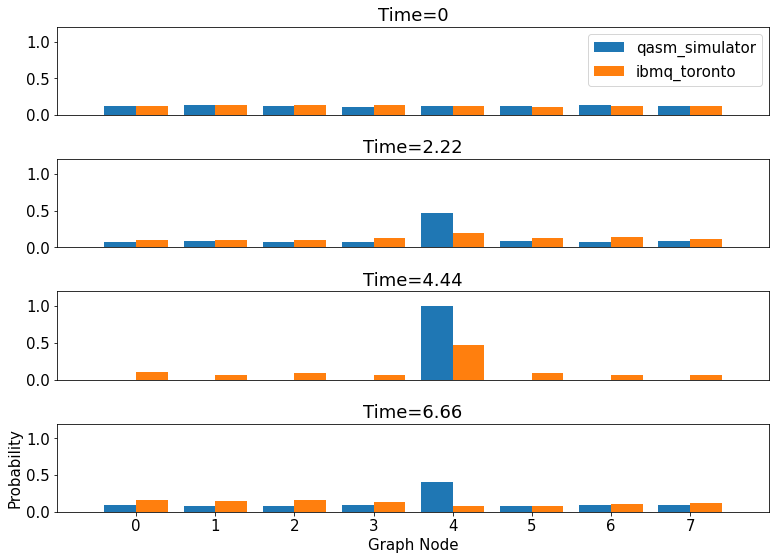

In [89]:
plotMultipleQiskitIbmSim(nq,maxFidDict,multResultSimN3,timeList,shots,True,backend3)